### Overview

PapirMoney, a fictitious wealth management company, recently surveyed their customers and found that the customers were split into two distinct groups based on where they primarily get their financial news. One group read financial sites like Forbes and Fortune and the other group primarily read general news sites like the NY Times and ABC News.  

PapirMoney is getting ready to launch a marketing campaign and wants to know the overall sentiment towards the US economy as well as whether there is any difference in sentiment between the financial news and the general news sources.

With the results of this sentiment analysis, the marketing team will be able to adapt their strategy based on overall trends for the different potential customer groups.

### Data Sources

This analysis uses headlines and article descriptions from [News API](https://newsapi.org/).
The specific news sources included in the api call are:
 * ABC News
 * The Associated Press
 * Axios
 * Bloomberg
 * Business Insider
 * CBS News
 * CNN
 * Forbes
 * Fortune
 * Google News
 * Newsweek
 * The New York Times
 * USA Today
 * The Wall Street Journal

### NLP Model

The sentiment analysis was done using a HuggingFace pipeline API. The pipeline API uses a pre-trained NLP model, in this case the RoBERTa model, to classify the news articles. Since the intent of this analysis is to see the overall economic news sentiment of the two customer groups, a pre-trained model will give us those results with a much quicker turnaround. Writing an NLP and training it from scratch would be too time and labor intensive for this specific task.

### Results and Recommendations

The overall sentiment is trending slightly positive. The financial news sources show a reletively even sentiment over the past month, but the general news had several large swings.

In the world clouds, there are quite a few topics that appear in both the business and general articles. Mentions of AI, technology and innovation appear in the business cloud. Focusing the marketing strategy for this group on the innovations that PapirMoney is making would likely be well recieved. 

The words in the general news positive cloud focus more on jobs and consumers rather than technology. Inflation and housing also appear in the general news negative cloud. The marketing campaign for this audience should focus more on the security and stability that the product can provide, ratcher than the technical innovations.




In [1]:

import sys
from datetime import datetime
import datetime

from transformers import pipeline
from tqdm.notebook import tqdm
import numpy as np 
import json
import requests
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from newsapi import NewsApiClient


News API has several API pricing [options](https://newsapi.org/pricing). This notebook uses the free Developer tier. It is limited to 100 requests per day, 100 articles per request, and can only return articles up to one month old. 

In order to get a large quantity of articles for this analysis we did several requests, each covering two days and combined all the results in one pandas dataframs.

Each request used the keyword 'economy and the following US based news sources:
 * ABC News
 * The Associated Press
 * Axios
 * Bloomberg
 * Business Insider
 * CBS News
 * CNN
 * Forbes
 * Fortune
 * Google News
 * Newsweek
 * The New York Times
 * USA Today
 * The Wall Street Journal


In [2]:
def get_news(from_date, to_date):
    """News API call"""
    
    api_key = 'fe48f920c2744194a81b82846cec1cbe'

    # Set the parameters for the request
    params = {
        'q': 'economy',
        'apiKey': api_key,
        'language': 'en',
        'sortBy': 'relevancy',
        'from': from_date,
        'to': to_date,
        'domains': 'cnn.com,nytimes.com,wsj.com,usatoday.com,forbes.com,bloomberg.com,abcnews.go.com,apnews.com,axios.com,businessinsider.com,cbsnews.com,fortune.com,news.google.com,newsweek.com'
    }

    # Make the request to the NewsAPI
    response = requests.get('https://newsapi.org/v2/everything', params=params)

    # Check if the request was successful
    if response.status_code == 200:
        articles = response.json()['articles']
        # Extracting relevant information
        data = []
        for article in articles:
            data.append({
                'title': article['title'],
                'source': article['source']['name'],
                'published_at': article['publishedAt'],
                'url': article['url'],
                'description': article['description']
            })
        # Create a DataFrame
        df = pd.DataFrame(data)
    else:
        print(f"Failed to fetch articles: {response.status_code}")
    return df

In [3]:
# First API call
from1 = '2024-06-20'
to1 = '2024-06-23'
df1 = get_news(from_date=from1, to_date=to1)


In [4]:
# Get range of dates to use for the remaining api calls
start = datetime.datetime.strptime("2024-06-20", "%Y-%m-%d")
end = datetime.datetime.strptime("2024-05-23", "%Y-%m-%d")
date_generated = [start - datetime.timedelta(days=x) for x in range(0, (start-end).days, 2)]

for date in date_generated:
    print(date.strftime("%Y-%m-%d"))

2024-06-20
2024-06-18
2024-06-16
2024-06-14
2024-06-12
2024-06-10
2024-06-08
2024-06-06
2024-06-04
2024-06-02
2024-05-31
2024-05-29
2024-05-27
2024-05-25


In [5]:
# Appending the results of each new api call to the previous.
for i in range(1,len(date_generated)):
    from1 = date_generated[i]
    to1 = date_generated[i-1]
    df2 = get_news(from_date=from1, to_date=to1)
    frames = [df1, df2]
    df1 = pd.concat(frames)
    df1 = df1.reset_index(drop=True)
df1.head()

,title,source,published_at,url,description
0,An airline startup that hopes to fly Airbus A3...,Business Insider,2024-06-20T20:40:11Z,https://www.businessinsider.com/startup-global...,"Since its launch, Global has touted a luxuriou..."
1,Trump thinks he can peel voters away from Bide...,Business Insider,2024-06-22T20:24:53Z,https://www.businessinsider.com/trump-biden-ph...,Trump thinks Philadelphia can help him flip Pe...
2,Stock market today: US stocks edge lower as AI...,Business Insider,2024-06-21T13:35:45Z,https://markets.businessinsider.com/news/stock...,Shares of Nvidia were down an additional 2% in...
3,Elon Musk predicts universal basic income will...,Business Insider,2024-06-22T12:14:01Z,https://www.businessinsider.com/elon-musk-univ...,"The Tesla and SpaceX chief predicts a ""univers..."
4,AI stock frenzy resembles dot-com bubble and m...,Business Insider,2024-06-20T12:10:11Z,https://markets.businessinsider.com/news/stock...,The epic surge in AI stocks led by Nvidia remi...


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366 entries, 0 to 1365
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1366 non-null   object
 1   source        1366 non-null   object
 2   published_at  1366 non-null   object
 3   url           1366 non-null   object
 4   description   1366 non-null   object
dtypes: object(5)
memory usage: 53.5+ KB


A very large majority of the articles are from Forbes. There are only a few from USA Today, the Associated Press, and the Wall Street Journal. Several of the sources in the Api call parameters did not return any articles.

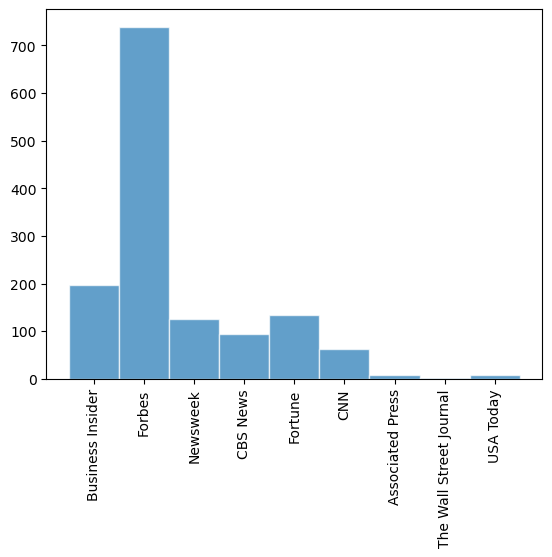

In [7]:
# Renaming the dataframe for clarity
df = df1

num_bins = df1['source'].nunique()
counts, bin_edges, patches = plt.hist(df1['source'], bins=num_bins, edgecolor='white', alpha=0.7)
plt.xticks(bin_edges, rotation=45)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.xticks(bin_centers, rotation=90)
plt.show()

The sentiment analysis was done using a HuggingFace pipeline API. The pipeline API uses a pre-trained NLP model, in this case the RoBERTa model, to classify the news articles. Since the intent of this analysis is to see the current overall economic news sentiment of the two customer groups, a pre-trained model will give us those results with a much quicker turnaround. Writing an NLP and training it from scratch would be too time and labor intensive for this specific task. 

In [8]:
model_id = "cardiffnlp/twitter-roberta-base-sentiment-latest"
classification = pipeline("sentiment-analysis", model=model_id)


C:\ProgramData\anaconda3\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exact

In [9]:
# We will run the classification on the article description which should provide more context than just the title
# without the additional time required for classifying articles of varying length, some of which could be very long.
descriptions = df['description'].to_list()

In [10]:
desc_class = classification(descriptions)


The HuggingFace pipeline returns labels of Neutral, Positive, and Negative with scores in each category ranging from 0 to 1. These scores are not very conducive to visualizing so we will drop the neutral articales and subtract the negative scores from 1. The new scale is 0 for the most negative up to 1 for the most positive. Neutral articles will also be dropped for the following visualizations.

In [11]:
probs = [d['score'] if d['label'].startswith('p') else 1 - d['score'] for d in desc_class ]
probs = pd.DataFrame(probs)
desc_class = pd.DataFrame(desc_class)
probs.columns = ['score']
desc_class = pd.concat([desc_class, probs['score'].rename('score_0_1')], axis=1)
desc_class.head()

,label,score,score_0_1
0,positive,0.875881,0.875881
1,neutral,0.723628,0.276372
2,neutral,0.503723,0.496277
3,positive,0.638712,0.638712
4,neutral,0.530860,0.469140


In [12]:
df = pd.concat([df, desc_class['score_0_1'].rename('score')], axis=1)
df = pd.concat([df, desc_class['label']], axis=1)
binary_score = ['positive', 'negative']
df = df[df['label'].isin(binary_score)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 635 entries, 0 to 1363
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         635 non-null    object 
 1   source        635 non-null    object 
 2   published_at  635 non-null    object 
 3   url           635 non-null    object 
 4   description   635 non-null    object 
 5   score         635 non-null    float64
 6   label         635 non-null    object 
dtypes: float64(1), object(6)
memory usage: 39.7+ KB


In [13]:
# Dropped the time from published at for plotting daily averages.
df['published_at'] = pd.to_datetime(df['published_at']).dt.date
df.head()

,title,source,published_at,url,description,score,label
0,An airline startup that hopes to fly Airbus A3...,Business Insider,2024-06-20,https://www.businessinsider.com/startup-global...,"Since its launch, Global has touted a luxuriou...",0.875881,positive
3,Elon Musk predicts universal basic income will...,Business Insider,2024-06-22,https://www.businessinsider.com/elon-musk-univ...,"The Tesla and SpaceX chief predicts a ""univers...",0.638712,positive
5,I've been flying ultra-low-cost airlines for y...,Business Insider,2024-06-21,https://www.businessinsider.com/spirit-frontie...,The a-la-carte business model used by carriers...,0.231128,negative
9,"Wyoming, Delaware, and Montana are the most en...",Business Insider,2024-06-21,https://www.businessinsider.com/low-tax-states...,"Wyoming, Delaware, and Montana lead the US in ...",0.892574,positive
10,I booked a weeklong trip to a mystery destinat...,Business Insider,2024-06-20,https://www.businessinsider.com/booked-solo-tr...,I booked a surprise trip to a mystery destinat...,0.696106,positive


Acatter plot of all scores from all sources. There are no clear trends visible in this view.

C:\Users\megha\AppData\Local\Temp\ipykernel_686280\1600166275.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


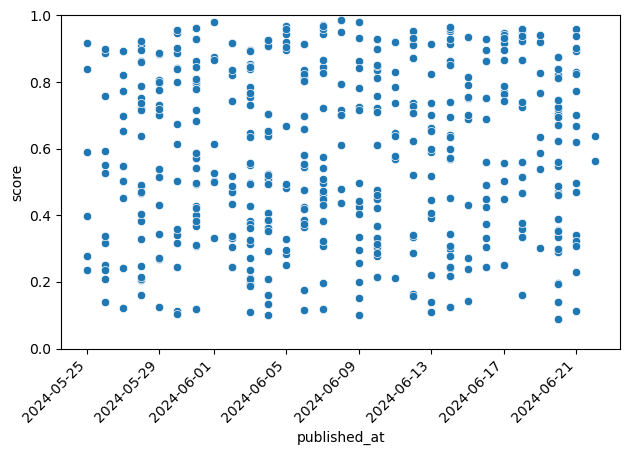

In [14]:
sns.scatterplot(data=df, x="published_at", y="score") 
ax=plt.gca()
ax.set_ylim([0, 1])
plt.suptitle('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [15]:
# Saving DF to a csv file to create the Tableau dashboard
df.to_csv('financial_news.csv', index=False)

The average sentiment is around 0.6 across the entire month for all sources. 

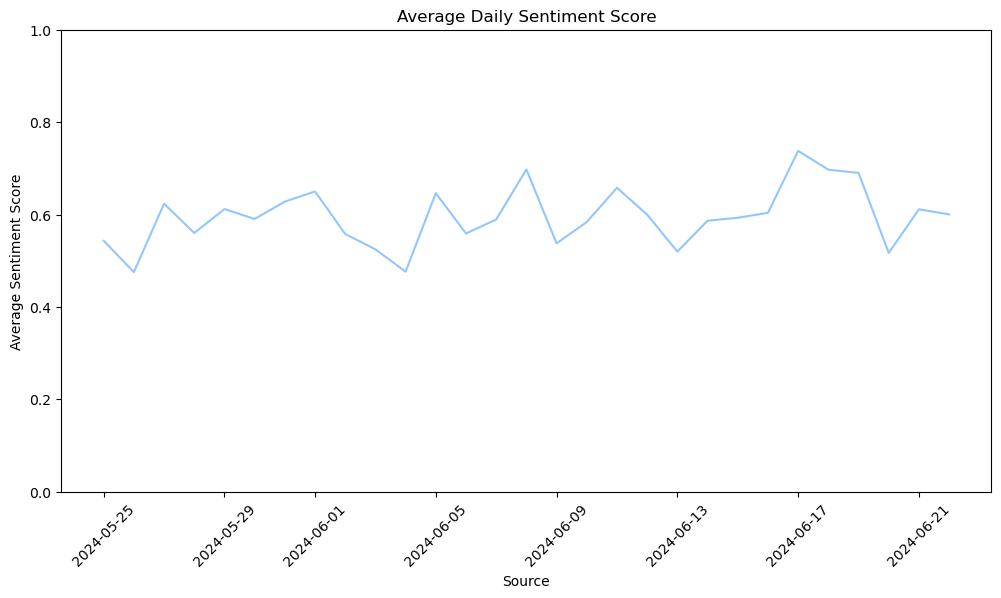

In [16]:
plt.style.use('default')
plt.style.use('seaborn-v0_8-pastel')
plt.figure(figsize=(12, 6))
df.groupby(df['published_at'])['score'].mean().plot(kind="line",rot=45)
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Source')
plt.title('Average Daily Sentiment Score')
ax=plt.gca()
ax.set_ylim([0, 1])
plt.suptitle('')
plt.show()

Forbes had the highest median score among all sources followed by CBS News and Business Insider.

<Figure size 1200x600 with 0 Axes>

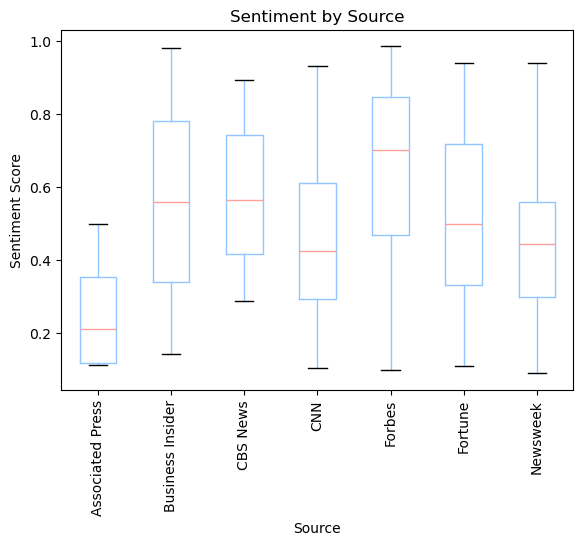

In [17]:
plt.figure(figsize=(12, 6))
df.boxplot(column='score', by='source', grid=False, rot=90)
plt.title('Sentiment by Source')
plt.suptitle('')
plt.xlabel('Source')
plt.ylabel('Sentiment Score')
plt.show()

The daily average score from the business news sources more closely resemble the overall plot, however the general news plot has much larger swings day to day. 

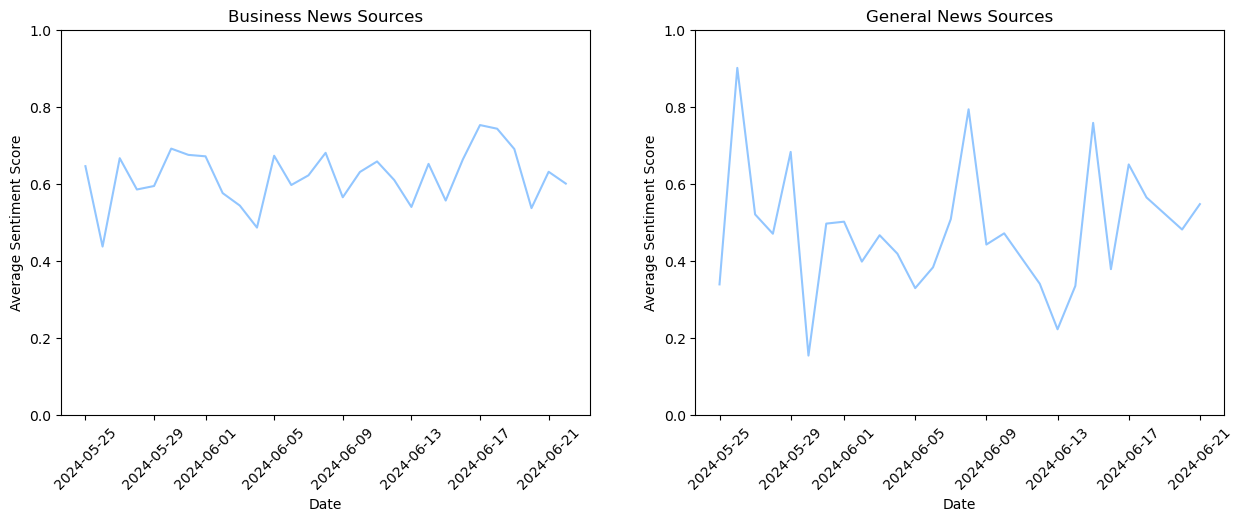

In [18]:
business_sources = ['Forbes', 'Business Insider', 'Fortune', 'The Wall Street Journal']
general_sources = ['Associated Press', 'CBS News', 'CNN', 'Newsweek', 'USA Today']

business_news = df[df['source'].isin(business_sources)]
general_news = df[df['source'].isin(general_sources)]


plt.style.use('default')
plt.style.use('seaborn-v0_8-pastel')

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
business_news.groupby(df['published_at'])['score'].mean().plot(kind="line",rot=45)
plt.title('Business News Sources')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Date')
ax=plt.gca()
ax.set_ylim([0, 1])
plt.suptitle('')

plt.subplot(1, 2, 2)
general_news.groupby(df['published_at'])['score'].mean().plot(kind="line",rot=45)
plt.title('General News Sources')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Date')
ax=plt.gca()
ax.set_ylim([0, 1])
plt.suptitle('')

plt.show()

Forbes had nearly twice as many positive articles as negative. CNN had more negative than positive. The other sources that had multiple articles were pretty evenly split between positive and negative.

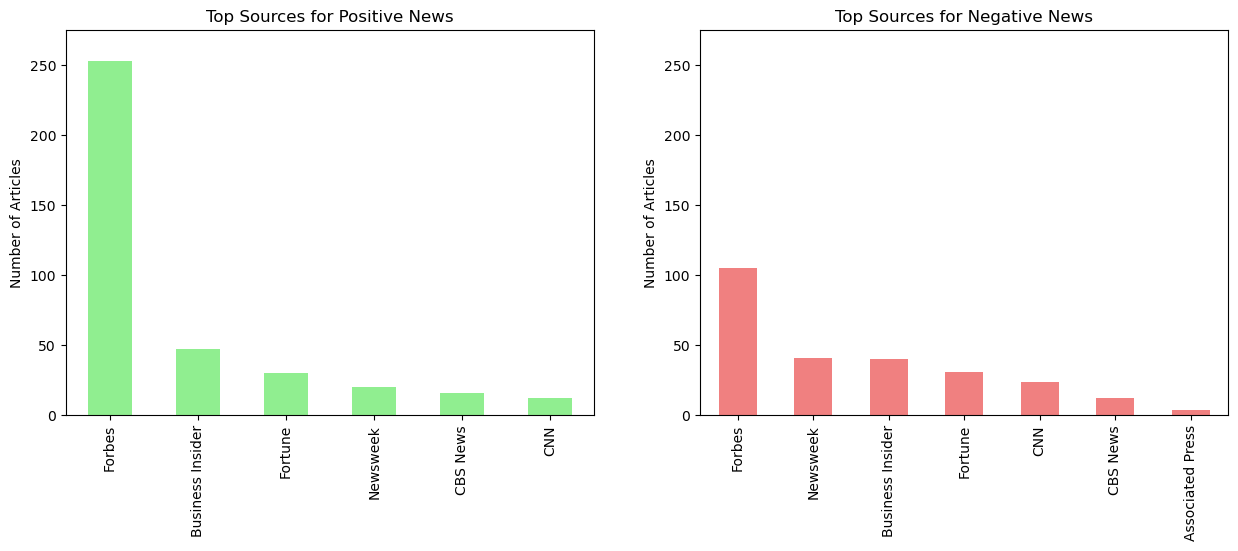

In [23]:
top_positive_sources = df[df['score'] > 0.5]['source'].value_counts().head(10)
top_negative_sources = df[df['score'] < 0.5]['source'].value_counts().head(10)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
top_positive_sources.plot(kind='bar', color='lightgreen')
plt.title('Top Sources for Positive News')
plt.ylabel('Number of Articles')
plt.ylim(0, 275)

plt.subplot(1, 2, 2)
top_negative_sources.plot(kind='bar', color='lightcoral')
plt.title('Top Sources for Negative News')
plt.ylabel('Number of Articles')
plt.ylim(0,275)

plt.show()

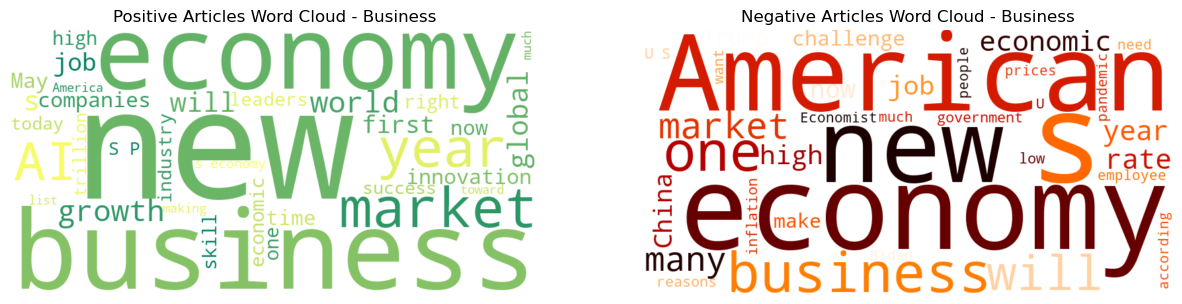

In [20]:
# Creating word clouds for the most common words in the Business articles
from wordcloud import WordCloud

positive_text = ' '.join(business_news[business_news['score'] > 0.5]['description'].dropna())
negative_text = ' '.join(business_news[business_news['score'] < 0.5]['description'].dropna())

positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='summer_r', max_words=35).generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gist_heat', max_words=35).generate(negative_text)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Articles Word Cloud - Business')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Articles Word Cloud - Business')

plt.show()


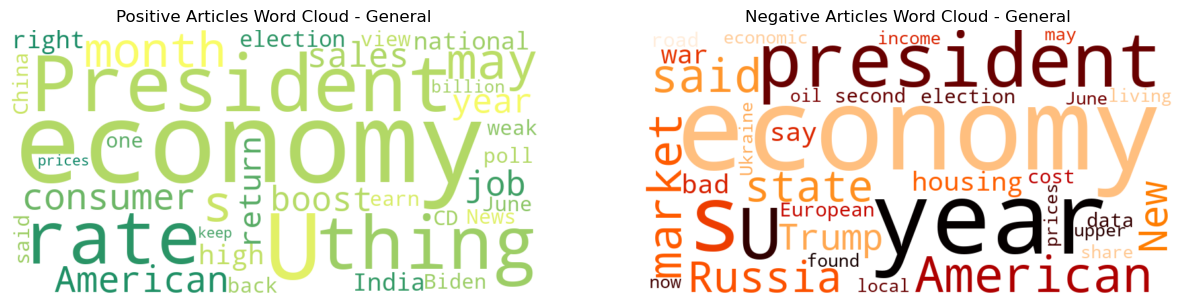

In [21]:
# Creating word clouds for the most common words in the Business articles
positive_text = ' '.join(general_news[general_news['score'] > 0.5]['description'].dropna())
negative_text = ' '.join(general_news[general_news['score'] < 0.5]['description'].dropna())

positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='summer_r', max_words=35).generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gist_heat', max_words=35).generate(negative_text)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Articles Word Cloud - General')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Articles Word Cloud - General')

plt.show()